In [1]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import time
# from adjustText import adjust_text
from pprintpp import PrettyPrinter
from scipy import interp
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
# font = {'size'   : 22}
# params = {'legend.fontsize': 20,
#           'legend.handlelength': 2}
# plt.rcParams.update(params)
# plt.rc('font', **font)

In [2]:
# Conductivity values are from https://www.angstromsciences.com/elements-electrical-conductivity
df = pd.read_excel("../../data/hammerfeld_criterion/Elemental_conductivities.xlsx")
df2 = pd.read_csv("../../data/hammerfeld_criterion/molar_refractivities.csv")

df2 = df2[['Atomic number', 'Molar volume', 'Polarizability']].drop_duplicates(subset=['Atomic number'])
df2.index = df2['Atomic number']
df2.drop(columns=['Atomic number'], inplace=True)
df = df.join(df2, on='#')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 10 columns):
Electrical Conductivity Ang        79 non-null float64
conductivity_unit1                 86 non-null object
Name                               88 non-null object
Symbol                             88 non-null object
#                                  88 non-null int64
Electrical Conductivity Wolfram    78 non-null float64
conductivity_unit2                 86 non-null object
Note                               1 non-null object
Molar volume                       86 non-null float64
Polarizability                     88 non-null float64
dtypes: float64(4), int64(1), object(5)
memory usage: 7.0+ KB


We log transform the conductivity since it is generally going to be a little easier to handle numerically when there is such a huge range of values. We also divide by 100 to convert from ($\Omega$m)$^{-1}$ to ($\Omega$cm)$^{-1}$

In [3]:
df['log_cond'] = np.log10(df['Electrical Conductivity Wolfram']/100)
df.head()

,Electrical Conductivity Ang,conductivity_unit1,Name,Symbol,#,Electrical Conductivity Wolfram,conductivity_unit2,Note,Molar volume,Polarizability,log_cond
0,NaN,NaN,Hydrogen,H,1,NaN,NaN,NaN,0.011210,0.666793,NaN
1,NaN,NaN,Helium,He,2,NaN,NaN,NaN,0.022424,0.204956,NaN
2,1.080000e-01,10^6/cm,Lithium,Li,3,1.100000e+07,1/m Ω,NaN,0.000013,24.300000,5.041393
3,3.130000e-01,10^6/cm Ω,Beryllium,Be,4,2.500000e+07,1/m Ω,NaN,0.000005,5.600000,5.397940
4,1.000000e-12,10^6/cm Ω,Boron,B,5,1.000000e-04,1/m Ω,NaN,0.000004,3.030000,-6.000000


In [4]:
df = df.dropna(subset=['log_cond'])

In [5]:
df.describe()

,Electrical Conductivity Ang,#,Electrical Conductivity Wolfram,Molar volume,Polarizability,log_cond
count,7.600000e+01,78.000000,7.800000e+01,78.000000,78.000000,78.000000
mean,9.066608e-02,49.500000,8.973115e+06,0.000017,15.989231,3.750734
std,1.258432e-01,25.498536,1.230190e+07,0.000011,11.826051,3.669199
min,5.000000e-24,3.000000,1.000000e-15,0.000004,1.760000,-17.000000
25%,1.165000e-02,28.250000,1.225000e+06,0.000009,6.800000,4.087872
50%,4.850000e-02,49.500000,4.900000e+06,0.000014,11.250000,4.690106
75%,1.107500e-01,70.750000,1.175000e+07,0.000020,24.252500,5.069734
max,6.300000e-01,94.000000,6.200000e+07,0.000071,59.420000,5.792392


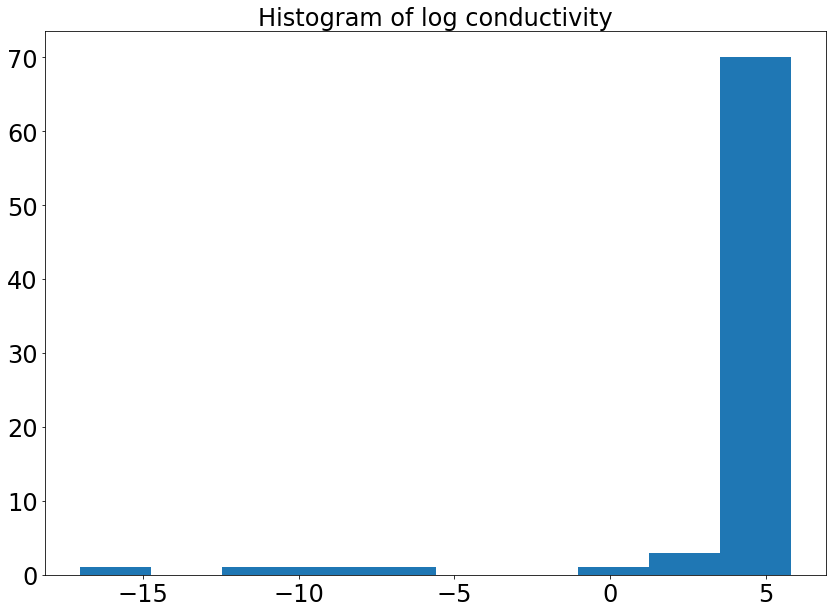

In [6]:
fontsize = 24
fig, ax = plt.subplots(figsize=(14,10))
df.hist(ax=ax, column='log_cond', grid=False)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsize)
plt.title('Histogram of log conductivity', fontsize=24)
plt.show()

In [7]:
df['metallic'] = df['log_cond'].apply(lambda x: np.where(x <= 3.0, 0, 1))
df.head()

,Electrical Conductivity Ang,conductivity_unit1,Name,Symbol,#,Electrical Conductivity Wolfram,conductivity_unit2,Note,Molar volume,Polarizability,log_cond,metallic
2,1.080000e-01,10^6/cm,Lithium,Li,3,1.100000e+07,1/m Ω,NaN,0.000013,24.30,5.041393,1
3,3.130000e-01,10^6/cm Ω,Beryllium,Be,4,2.500000e+07,1/m Ω,NaN,0.000005,5.60,5.397940,1
4,1.000000e-12,10^6/cm Ω,Boron,B,5,1.000000e-04,1/m Ω,NaN,0.000004,3.03,-6.000000,0
5,6.100000e-04,10^6/cm Ω,Carbon,C,6,1.000000e+05,1/m Ω,Graphite,0.000005,1.76,3.000000,0
6,2.100000e-01,10^6/cm Ω,Sodium,Na,11,2.100000e+07,1/m Ω,NaN,0.000024,24.11,5.322219,1


# Featurize elements

In [8]:
from matminer.featurizers.conversions import StrToComposition
df = StrToComposition().featurize_dataframe(df, 'Symbol')

In [9]:
from matminer.featurizers.composition import ElementProperty

ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id="composition", ignore_errors=True)
df.head()

,Electrical Conductivity Ang,conductivity_unit1,Name,Symbol,#,Electrical Conductivity Wolfram,conductivity_unit2,Note,Molar volume,Polarizability,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
2,1.080000e-01,10^6/cm,Lithium,Li,3,1.100000e+07,1/m Ω,NaN,0.000013,24.30,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0
3,3.130000e-01,10^6/cm Ω,Beryllium,Be,4,2.500000e+07,1/m Ω,NaN,0.000005,5.60,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
4,1.000000e-12,10^6/cm Ω,Boron,B,5,1.000000e-04,1/m Ω,NaN,0.000004,3.03,...,0.0,0.0,0.0,0.0,166.0,166.0,0.0,166.0,0.0,166.0
5,6.100000e-04,10^6/cm Ω,Carbon,C,6,1.000000e+05,1/m Ω,Graphite,0.000005,1.76,...,0.0,0.0,0.0,0.0,194.0,194.0,0.0,194.0,0.0,194.0
6,2.100000e-01,10^6/cm Ω,Sodium,Na,11,2.100000e+07,1/m Ω,NaN,0.000024,24.11,...,0.0,0.0,0.0,0.0,229.0,229.0,0.0,229.0,0.0,229.0


# Remove features with 0 variance

In [10]:
def remove_redundant_features(X):
    """Drops zero variance and highly correlated features from DataFrame."""
    variances = X.var()
    backup = X['MagpieData minimum Number'].copy()
    to_drop = [column for column in variances.index if variances[column] == 0]
    X.drop(columns=to_drop, inplace=True)
    
    # Create correlation matrix
    corr_matrix = X.corr().abs() # Remove text variables before finding correlations

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.97
    to_drop = [column for column in upper.columns if any(upper[column] > 0.97)]

    X.drop(columns=to_drop, inplace=True)
    
    # Manually keep atomic numbers
    X['MagpieData minimum Number'] = backup
    
    return X

In [11]:
df = remove_redundant_features(df)
df.head()

,Electrical Conductivity Ang,conductivity_unit1,Name,Symbol,#,conductivity_unit2,Note,Molar volume,Polarizability,log_cond,...,MagpieData minimum NsUnfilled,MagpieData minimum NpUnfilled,MagpieData minimum NdUnfilled,MagpieData minimum NfUnfilled,MagpieData minimum NUnfilled,MagpieData minimum GSvolume_pa,MagpieData minimum GSbandgap,MagpieData minimum GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData minimum Number
2,1.080000e-01,10^6/cm,Lithium,Li,3,1/m Ω,NaN,0.000013,24.30,5.041393,...,1.0,0.0,0.0,0.0,1.0,16.593333,0.000,0.0,229.0,3.0
3,3.130000e-01,10^6/cm Ω,Beryllium,Be,4,1/m Ω,NaN,0.000005,5.60,5.397940,...,0.0,0.0,0.0,0.0,0.0,7.890000,0.000,0.0,194.0,4.0
4,1.000000e-12,10^6/cm Ω,Boron,B,5,1/m Ω,NaN,0.000004,3.03,-6.000000,...,0.0,5.0,0.0,0.0,5.0,7.172500,1.524,0.0,166.0,5.0
5,6.100000e-04,10^6/cm Ω,Carbon,C,6,1/m Ω,Graphite,0.000005,1.76,3.000000,...,0.0,4.0,0.0,0.0,4.0,5.640000,4.496,0.0,194.0,6.0
6,2.100000e-01,10^6/cm Ω,Sodium,Na,11,1/m Ω,NaN,0.000024,24.11,5.322219,...,1.0,0.0,0.0,0.0,1.0,29.243333,0.000,0.0,229.0,11.0


Drop ground state band gap to avoid cheating

In [12]:
drop_bg = True
if drop_bg:
    df = df.drop('MagpieData minimum GSbandgap', axis=1)
df.to_csv("../../data/hammerfeld_criterion/featurized_elements.csv",index=False)
df.columns

Index(['Electrical Conductivity Ang', 'conductivity_unit1', 'Name', 'Symbol',
       '#', 'conductivity_unit2', 'Note', 'Molar volume', 'Polarizability',
       'log_cond', 'metallic', 'composition',
       'MagpieData minimum MendeleevNumber', 'MagpieData minimum MeltingT',
       'MagpieData minimum Column', 'MagpieData minimum Row',
       'MagpieData minimum CovalentRadius',
       'MagpieData minimum Electronegativity', 'MagpieData minimum NsValence',
       'MagpieData minimum NpValence', 'MagpieData minimum NdValence',
       'MagpieData minimum NfValence', 'MagpieData minimum NValence',
       'MagpieData minimum NsUnfilled', 'MagpieData minimum NpUnfilled',
       'MagpieData minimum NdUnfilled', 'MagpieData minimum NfUnfilled',
       'MagpieData minimum NUnfilled', 'MagpieData minimum GSvolume_pa',
       'MagpieData minimum GSmagmom', 'MagpieData minimum SpaceGroupNumber',
       'MagpieData minimum Number'],
      dtype='object')

Drop redundant labels to make later plots smaller

In [13]:
def abbreviate(word):
        '''Replace long names with shorter ones.'''
        replacements = {'MagpieData ': '',
                       'minimum ': ''}
    
        for item, abbrv in replacements.items():
            word = word.replace(item, abbrv)
        return word
def abbreviate_features(X):
    """Renames columns in DataFrame to make plots fit better."""
    orig_names = list(X)
    new_names = [abbreviate(word) for word in orig_names]
    column_names = dict(zip(orig_names, new_names))
    X.rename(index=str, columns=column_names, inplace=True)
    return X
df = abbreviate_features(df)

# Run classifier model to predict metallicity

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def get_scores(X, y, model, metric, test_size=0.15):
    """Computes a model metric across CV runs."""
    scores = []
    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            X.drop(columns=['Symbol']), y, test_size=test_size, random_state=seed)
        model.fit(X_train, y_train)

        # Estimate score
        y_pred = model.predict(X_test)
        score = metric(y_test, y_pred)
        scores.append(score)
        
    return scores

In [15]:
X = df.drop(columns=['Electrical Conductivity Ang',
                     'conductivity_unit1',
                     'Name',
                     '#',
                     'conductivity_unit2',
                     'Note',
                     'composition', 
                     'log_cond',
                     'metallic'])
y = df.loc[:, 'metallic']

## Access accuracy across 10 different runs using 20% of data as test set

In [16]:
# Function for hyperparameter selection
from sklearn.model_selection import GridSearchCV
def grid_search(model):
    """Conducts grid search to find optimal model hyperparameters for all 3 classes."""
    param_grid = {'n_estimators': [10, 20, 40, 80, 100, 150, 200], 
                 'max_depth': [2, 3, 5],
                 'learning_rate': np.logspace(-3, 2, num=6)
                 }
    xgb = GridSearchCV(model, param_grid, cv=5, n_jobs=8)
    X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=['Symbol']), y, test_size=0.2)
    t0 = time.time()
    xgb.fit(X_train, y_train)
    xgb_fit = time.time() - t0
    print("XGB hyperparameters selected in %.3f s"
          % (xgb_fit))
    params = xgb.best_params_
    return params

In [17]:
model = GradientBoostingClassifier()
best_params = grid_search(model)
print(best_params)
model = GradientBoostingClassifier(**best_params)

XGB hyperparameters selected in 4.155 s
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


/home/nicholas/miniconda3/envs/dev/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [18]:
scores = get_scores(X, y, model, metric=accuracy_score, test_size=0.20)
print(scores)
mean, conf_interval = mean_confidence_interval(scores, confidence=0.95)
print('Mean accuracy: {:0.2f}+/-{:0.2f}'.format(mean, conf_interval))

[0.9375, 1.0, 0.8125, 0.9375, 0.9375, 0.875, 0.8125, 0.875, 0.875, 0.9375]
Mean accuracy: 0.90+/-0.04


# Plot train vs test results

In [19]:
def plot_train_test(X, y, test_size=0.15, seed=2, figsize=(6, 8), dpi=150, s=12, labelsize=16):
    """Trains metallicity model and scatter plots predictions.
    
    Args:
        X (pandas Dataframe): input features
        y (pandas Dataframe): ground truth labels of metallicity
        test_size (Float): portion of data set aside for testing, remainder will be trained on
        seed (Integer): random seed for shuffling data
        figsize (Tuple): dimensions of output figure
        dpi (Integer): dots per inch resolution of figure
        s (Integer): size of dots in scatter plot
        labelsize (Integer): fontsize for names of elements
    """
    X_train, X_test, y_train, y_test = train_test_split(
            X.drop(columns=['Symbol']), y, test_size=test_size, random_state=seed)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Plot training set
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.scatter(y_train, X_train['Number'], s=s)
    
    texts =[]
    # Plotting utility function
    def plot_subset(mask):
        X_subset = X_test['Number'].values[mask]
        y_subset = y_test.values[mask]
        plt.scatter(y_subset, X_subset, s=s)
        labels = [X.loc[X['Number'] == x, 'Symbol'].values[0] for x in X_subset]
        for i, txt in enumerate(labels):
            plt.annotate(labels[i], 
                         (y_subset[i], X_subset[i]),
                        fontsize=labelsize,
                        ha='right',
                        va='center',
                        xytext=(-4, 0),
                        textcoords='offset points')
#             texts.append(plt.text(y_subset[i], 
#                           X_subset[i],
#                           labels[i],
#                         clip_on=True,
#                         fontsize=20))
            
    # Plot correctly predicted elements in test set
    mask = np.equal(y_test.values, predictions)
    plot_subset(mask)
    
    # Plot incorrectly predicted elements in test set
    mask = np.invert(mask)
    plot_subset(mask)
    
    plt.axis("tight")
    plt.ylabel("Atomic Number", fontsize=24)
    plt.xlabel("True Metallicity", fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.legend(['Training', 'Test_correct', 'Test_wrong'], fontsize=12)
#     adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5), lim=200)
    plt.show()

## Plot which test set elements are guessed correctly and incorrectly

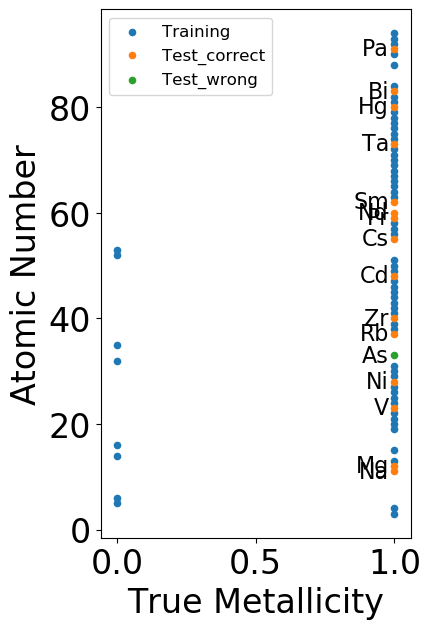

In [20]:
# Play around with seed to change test set
# Increase test size to change difficulty
# It is possible to get near perfect accuracies even with only 1/4 the elements in training!
model = GradientBoostingClassifier(**best_params)
plot_train_test(X, y, test_size=0.20, seed=4, figsize=(4,7), s=20, labelsize=16, dpi=100)

# Phosphorus seems like an outlier...

Turns out Wolfram's value is probably for a particular direction in a single crystal.
A measurement from the 1950's says phosphorus's resistivity is closer to tellurium. https://doi.org/10.1103/PhysRev.92.580
So maybe we should reclassify it.

In [21]:
# Let's correct that and replot
ind = X.loc[X['Symbol'] == 'P'].index  # Get index
y[ind] = 0
model = GradientBoostingClassifier(**best_params)

In [22]:
scores = get_scores(X, y, model, metric=accuracy_score, test_size=0.20)
print(scores)
mean, conf_interval = mean_confidence_interval(scores, confidence=0.95)
print('Mean accuracy: {:0.2f}+/-{:0.2f}'.format(mean, conf_interval))

[0.9375, 1.0, 0.8125, 1.0, 0.9375, 0.9375, 0.8125, 0.9375, 0.875, 0.9375]
Mean accuracy: 0.92+/-0.05


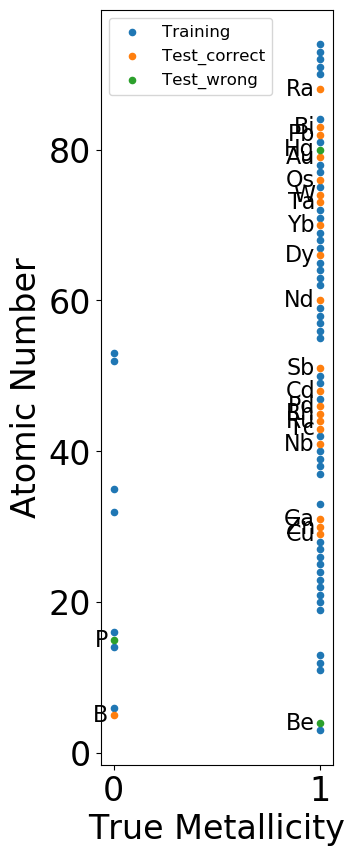

In [23]:
plot_train_test(X, y, test_size=0.30, seed=150, figsize=(3,10), s=20, labelsize=16, dpi=100)

# Some plots for different classification metrics

In [24]:
def roc_plot(X, y, seed=0, splits=5, figsize=(10, 5)):
    cv = KFold(n_splits=splits,shuffle=True,random_state=seed)
    X = X.drop(columns=['Symbol']).values
    y = y.values
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 1
    fig = plt.figure(figsize=figsize)
#     X_train, X_test, y_train, y_test = train_test_split(
#     X.drop(columns=['Symbol']), y, test_size=test_size, random_state=seed)
    for train, test in cv.split(X, y):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.8,
                 label='Fold %d (AUC = %0.2f)' % (i, roc_auc))
        i+=1
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=24)
    plt.ylabel('True Positive Rate', fontsize=24)
    plt.legend(loc="lower right", fontsize=20)
    plt.show()

In [25]:
def prec_recall_curve(X, y, test_size=0.2, seed=0, figsize=(10, 5)):
    X_train, X_test, y_train, y_test = train_test_split(
        X.drop(columns=['Symbol']), y, test_size=test_size, random_state=seed)
    model.fit(X_train, y_train)
    y_score = model.decision_function(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision = average_precision_score(y_test, y_score)
    
    fig = plt.figure(figsize=figsize)
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', fontsize=24)
    plt.ylabel('Precision', fontsize=24)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

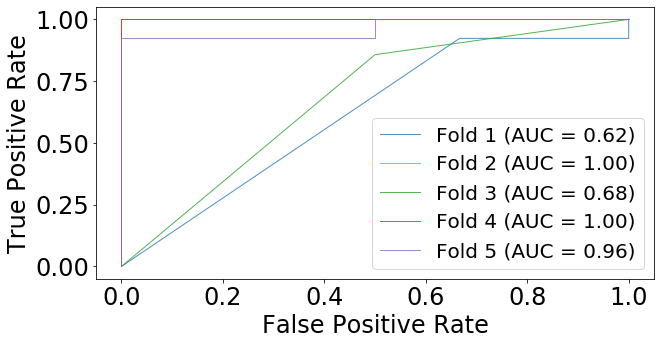

In [26]:
roc_plot(X, y, seed=12, figsize=(10, 5))

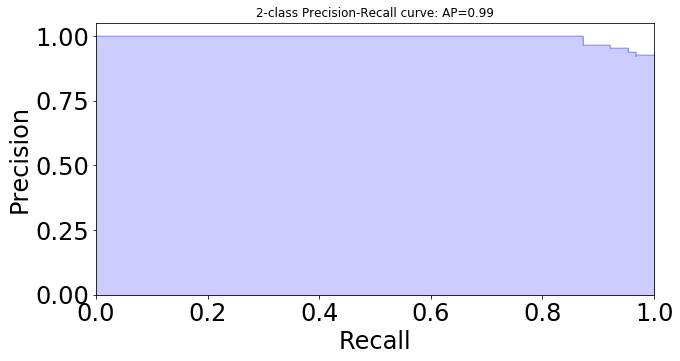

In [27]:
prec_recall_curve(X, y, test_size=0.90, seed=1, figsize=(10, 5))

# Use SHAP to analyze what the model has learned

In [28]:
model.fit(X.drop(columns=['Symbol']), y)
explainer = shap.TreeExplainer(model, model_output="margin")
shap_values = explainer.shap_values(X.drop(columns=['Symbol']))

In [29]:
X.drop(columns=['Symbol']).columns

Index(['Molar volume', 'Polarizability', 'MendeleevNumber', 'MeltingT',
       'Column', 'Row', 'CovalentRadius', 'Electronegativity', 'NsValence',
       'NpValence', 'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
       'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled', 'GSvolume_pa',
       'GSmagmom', 'SpaceGroupNumber', 'Number'],
      dtype='object')

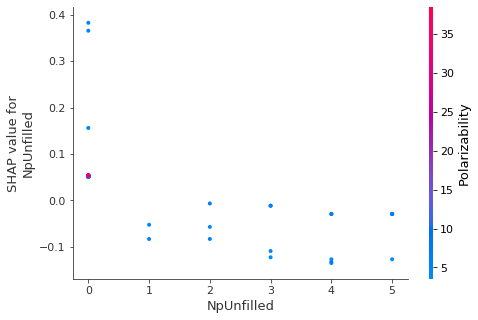

In [30]:
shap.dependence_plot('NpUnfilled', shap_values, X.drop(columns=['Symbol']),interaction_index='Polarizability')

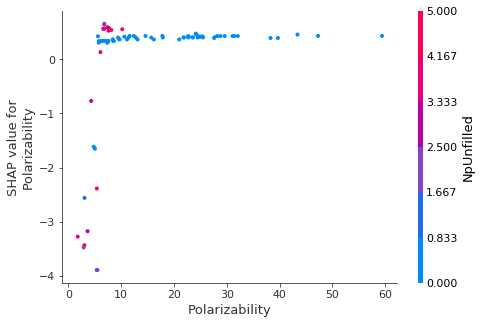

In [31]:
shap.dependence_plot('Polarizability', shap_values, X.drop(columns=['Symbol']),interaction_index='NpUnfilled')

In [32]:
# ind = 34
# for ind in range(len(X)):
#     print('SHAP values for {}'.format(X.iloc[ind,0]))
#     shap.force_plot(
#         explainer.expected_value, 
#         shap_values[ind], 
#         X.drop(columns=['Symbol']).round(2).iloc[ind], 
#         matplotlib=True, 
#         show=False,
#         figsize=(20, 4),
#         )
#     # plt.savefig("../plots/paper_figures/SHAP_MoO2.pdf", dpi=400)
#     plt.show()

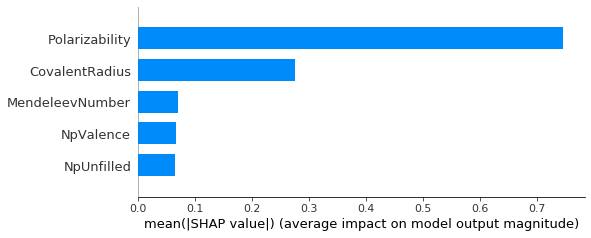

In [33]:
shap.summary_plot(shap_values, X.drop(columns=['Symbol']), plot_type="bar", max_display=5, show=False)
# plt.savefig("../../plots/goldhammer_herzfeld_elements/SHAP_classification_mean.pdf", dpi=200, bbox_inches='tight')

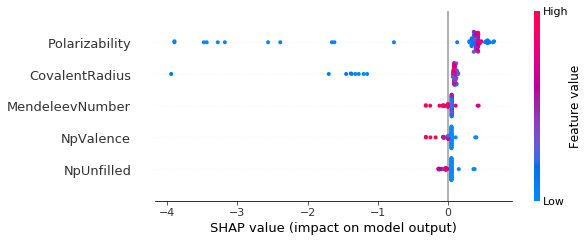

In [34]:
# fig = plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values, X.drop(columns=['Symbol']), 
                  max_display=5, auto_size_plot=True, plot_type='dot', show=False)
# plt.tight_layout()
# plt.savefig("../../plots/goldhammer_herzfeld_elements/SHAP_classification.pdf", 
#             dpi=200, bbox_inches='tight')
# ax = plt.gca()
# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(20)


In [35]:
model.score(X.drop(columns=['Symbol']), y)

1.0

# Use UMAP to cluster data

In [36]:
import umap

In [37]:
# Standardize data for projection
vals = X.drop(columns=['Symbol']).values
scaler = preprocessing.StandardScaler()
scaled_vals = scaler.fit_transform(vals)
newX = pd.DataFrame(scaled_vals, columns=X.drop(columns=['Symbol']).columns)

In [38]:
# embedding = umap.UMAP(n_neighbors=5).fit_transform(newX.values, y=y)
embedding = umap.UMAP(n_neighbors=4).fit_transform(newX.values)

/home/nicholas/miniconda3/envs/dev/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../miniconda3/envs/dev/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/home/nicholas/miniconda3/envs/dev/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../miniconda3/envs/dev/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/home/nicholas/miniconda3/envs/dev/lib/python3.7/site-packages/numba/compiler.py:734: NumbaD

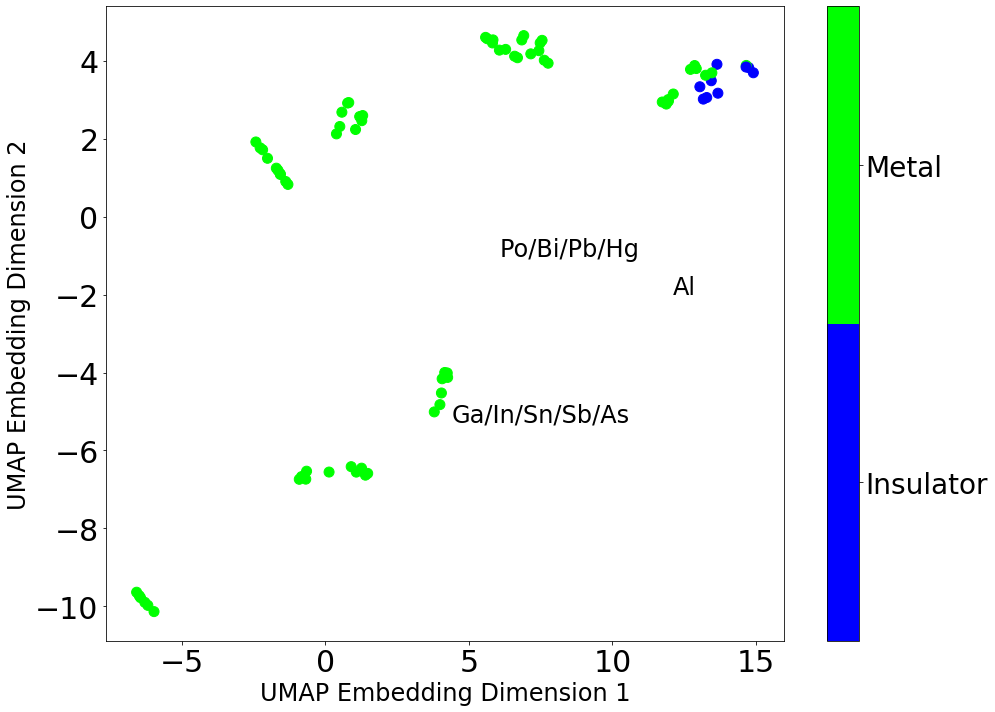

In [39]:
# Be default, UMAP reduces to 2 dimensions for viewing in a scatter plot
fig, ax = plt.subplots(1, figsize=(14, 10))
cmap = plt.cm.brg  # define the colormap

# extract all colors from the .viridis map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 1, 3)
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(*embedding.T, s=100, c=y.values.ravel(), cmap=cmap, norm=norm, alpha=1.0)
plt.tick_params(axis='both', which='major', labelsize=30)
# plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(ax=ax)
# cbar.set_ticks([0.25, 0.75])
# cbar.ax.set_yticklabels(['  Metal\n    +\nInsulator', 'MIT'])
cbar.set_ticks([0.25, .75])
cbar.ax.set_yticklabels(['Insulator', 'Metal'])
# cbar.set_ticklabels(classes)
cbar.ax.tick_params(labelsize=28)
dictfont = {'fontsize': 24, "horizontalalignment": "center"}
# ax.text(12.5, -2, """Al""", fontdict=dictfont)
# ax.text(7.5, -5.25, """Ga/In/Sn/Sb/As""", fontdict=dictfont)
# ax.text(8.5, -1, """Po/Bi/Pb/Hg""", fontdict=dictfont)
plt.xlabel("UMAP Embedding Dimension 1", fontsize=24)
plt.ylabel("UMAP Embedding Dimension 2", fontsize=24)
# plt.title('Features Embedded via UMAP', fontdict={'fontsize': 32})
# plt.savefig("../plots/paper_figures/UMAP_embeddings_all.pdf", dpi=400)
plt.tight_layout()
# plt.savefig("../../plots/goldhammer_herzfeld_elements/UMAP_embeddings.pdf", dpi=200)
plt.show()

In [40]:
# See what elements are plotted at which locations
names = X['Symbol'].values.reshape((len(y), 1))
foo = np.concatenate((names, embedding, y.values.reshape((len(y), 1))), axis=1).tolist()
foo = sorted(foo, key=lambda x: (x[-1], x[-3]), reverse=True)
pp = PrettyPrinter()
pp.pprint(foo)

[
    ['Al', 14.665600776672363, 3.8854446411132812, 1],
    ['As', 13.467820167541504, 3.6955959796905518, 1],
    ['Sb', 13.2485990524292, 3.6338024139404297, 1],
    ['Sn', 12.923869132995605, 3.8056225776672363, 1],
    ['Ga', 12.86722183227539, 3.8830373287200928, 1],
    ['In', 12.72321605682373, 3.7842395305633545, 1],
    ['Tl', 12.123165130615234, 3.152031898498535, 1],
    ['Po', 11.954071998596191, 2.968549966812134, 1],
    ['Pb', 11.947074890136719, 3.0084357261657715, 1],
    ['Bi', 11.879500389099121, 2.8936996459960938, 1],
    ['Hg', 11.738822937011719, 2.946477174758911, 1],
    ['Cd', 7.761081218719482, 3.9428112506866455, 1],
    ['Zn', 7.627798080444336, 4.019531726837158, 1],
    ['Fe', 7.5512471199035645, 4.5299296379089355, 1],
    ['Co', 7.484724044799805, 4.463927268981934, 1],
    ['Ni', 7.439957618713379, 4.264605522155762, 1],
    ['Mn', 7.158012390136719, 4.182911396026611, 1],
    ['Mg', 6.912588119506836, 4.651773452758789, 1],
    ['Be', 6.8437070846557

# Use regression to predict log of conductivity

Regression is usually harder than classification

In [41]:
X = df.drop(columns=['Electrical Conductivity Ang',
                     'conductivity_unit1',
                     'Name',
                     '#',
                     'conductivity_unit2',
                     'Note',
                     'composition', 
                     'log_cond',
                     'metallic'])
y = df.loc[:, 'log_cond']

In [42]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, r2_score

# GridSearchCV does not work with this regressor+data combination,
# so use default parameters.
model = XGBRegressor()

maes = get_scores(X, y, model, metric=mean_absolute_error, test_size=0.25)
mean, conf_interval = mean_confidence_interval(maes, confidence=0.95)
print('Mean mean absolute error: {:0.2f}+/-{:0.2f}'.format(mean, conf_interval))
r2s = get_scores(X, y, model, metric=r2_score, test_size=0.5)
mean, conf_interval = mean_confidence_interval(r2s, confidence=0.95)
print("Mean R2 score: {:0.2f}+/-{:0.2f}".format(mean, conf_interval))

Mean mean absolute error: 1.12+/-0.49
Mean R2 score: -0.79+/-1.45


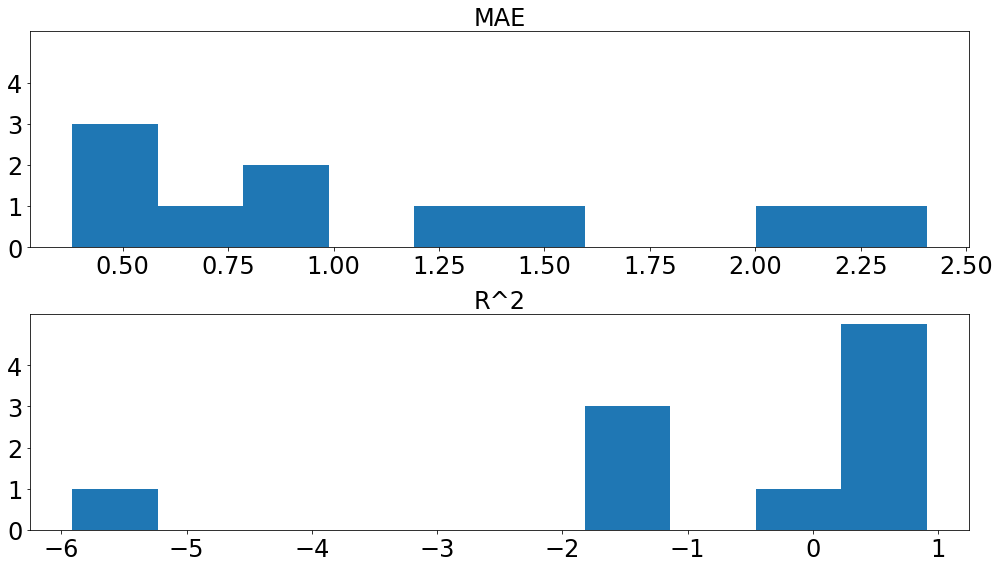

In [43]:
fig, axarr = plt.subplots(nrows=2, figsize=(14,8), sharey=True)
plt.yticks([0, 1, 2, 3, 4])
axarr[0].hist(maes)
axarr[0].set_title('MAE')
oldmaes = maes
axarr[1].hist(r2s)
axarr[1].set_title('R^2')
for ax in axarr:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
oldr2s = r2s
plt.tight_layout()
plt.show()

In [44]:
def plot_train_test_regression(X, y, test_size=0.15, seed=2, figsize=(6, 8), dpi=150, s=12, labelsize=16):
    """Trains metallicity model and scatter plots predictions.
    
    Args:
        X (pandas Dataframe): input features
        y (pandas Dataframe): ground truth labels
        test_size (Float): portion of data set aside for testing, remainder will be trained on
        seed (Integer): random seed for shuffling data
        figsize (Tuple): dimensions of output figure
        dpi (Integer): dots per inch resolution of figure
        s (Integer): size of dots in scatter plot
        labelsize (Integer): fontsize for names of elements
    """
    X_train, X_test, y_train, y_test = train_test_split(
            X.drop(columns=['Symbol']), y, test_size=test_size, random_state=seed)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions = np.reshape(predictions, (len(predictions), 1))
    
    # Plot training set
    fig = plt.figure(figsize=figsize, dpi=dpi)
#     plt.scatter(X_train['MagpieData minimum Number'], y_train, s=s)
    
    # Plot real test values
    plt.scatter(X_test['Number'], y_test, s=s)
    x_nums = X_test['Number'].values
    labels = [X.loc[X['Number'] == x, 'Symbol'].values[0] for x in x_nums]
    for i, txt in enumerate(labels):
        plt.annotate(labels[i], 
                     (x_nums[i], y_test.values[i]),
                    fontsize=labelsize,
                    ha='right',
                    va='center',
                    xytext=(-1.5, 1.5),
                    textcoords='offset points')
    
    # Plot predicted values
    plt.scatter(X_test['Number'], predictions, s=s*1.1, marker='+')
    
#     plt.ylim([-15.1, 8])
#     plt.axis("tight")
    plt.xlabel("Atomic Number", fontsize=24)
    plt.ylabel("Log conductivity", fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.legend(['Test', 'Predictions'])
#     plt.legend(['Training', 'Test', 'Predictions'])
    plt.show()

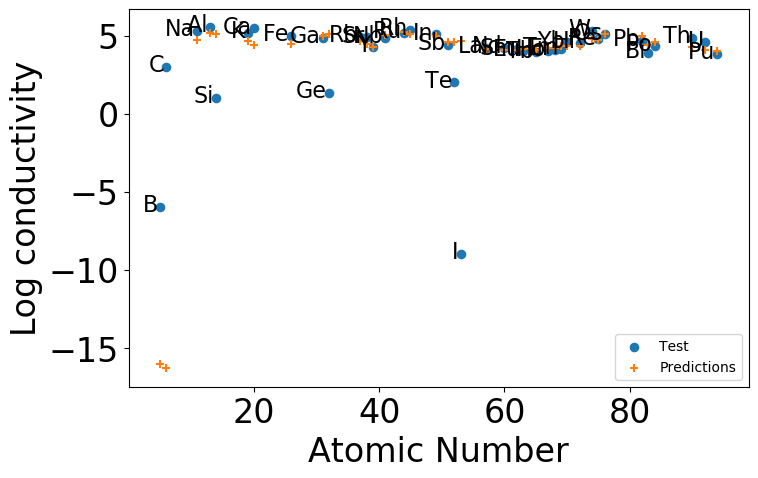

In [45]:
plot_train_test_regression(X, y, test_size=0.5, seed=0, figsize=(8, 5), labelsize=16, dpi=100, s=35)

# SHAP Analysis

In [46]:
model.fit(X.drop(columns=['Symbol']), y)
explainer = shap.TreeExplainer(model, model_output="margin")
shap_values = explainer.shap_values(X.drop(columns=['Symbol']))

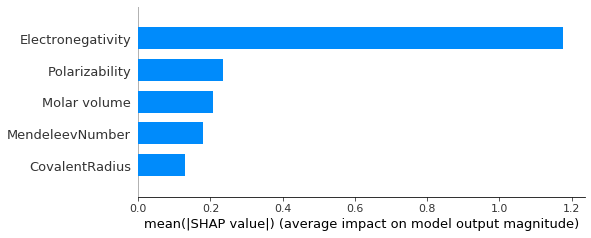

In [47]:
shap.summary_plot(shap_values, X.drop(columns=['Symbol']), plot_type="bar", max_display=5, show=False)
# plt.savefig("../../plots/goldhammer_herzfeld_elements/SHAP_regression_mean.pdf", dpi=200, bbox_inches='tight')

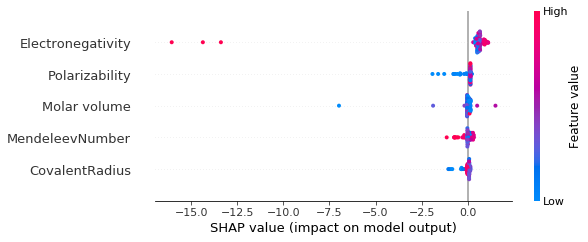

In [48]:
shap.summary_plot(shap_values, X.drop(columns=['Symbol']), 
                  max_display=5, auto_size_plot=True, plot_type='dot', show=False)
# plt.tight_layout()
# plt.savefig("../../plots/goldhammer_herzfeld_elements/SHAP_regression.pdf", dpi=200, bbox_inches='tight')

In [49]:
X.columns

Index(['Symbol', 'Molar volume', 'Polarizability', 'MendeleevNumber',
       'MeltingT', 'Column', 'Row', 'CovalentRadius', 'Electronegativity',
       'NsValence', 'NpValence', 'NdValence', 'NfValence', 'NValence',
       'NsUnfilled', 'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled',
       'GSvolume_pa', 'GSmagmom', 'SpaceGroupNumber', 'Number'],
      dtype='object')

In [50]:
model.score(X.drop(columns=['Symbol']),y)

0.9989484129819011